# Boosting-based estimator

In this notebook, we will present a second family of ensemble method known as boosting. We will first give an intuitive example of how boosting works. It will follow by an introduction to gradient boosting decision tree models.

In [1]:
# temporary fix to avoid spurious warning raised in scikit-learn 1.0.0
# it will be solved in scikit-learn 1.0.1
import warnings
warnings.filterwarnings("ignore", message="X has feature names.*")
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

## Introduction to boosting

We will first give an intuive explanation on the principle of boosting. In the previous notebook, we saw that bagging was creating several datasets with a little variation using bootstrapping. Then an estimator was trained on each of these different datasets and the different results were aggregated. In boosting, the paradigm is different: the estimators will be trained on the same dataset. Thus, to combine them, we will train an estimator to correct the error of all previous estimators. So, we have a sequence of estimators instead of independent estimators.

Let's give an example on a classification dataset.

In [2]:
import pandas as pd

data = pd.read_csv("../datasets/penguins_classification.csv")
data["Species"] = data["Species"].astype("category")
X, y = data[["Culmen Length (mm)", "Culmen Depth (mm)"]], data["Species"]

In [3]:
import seaborn as sns
sns.set_context("poster")

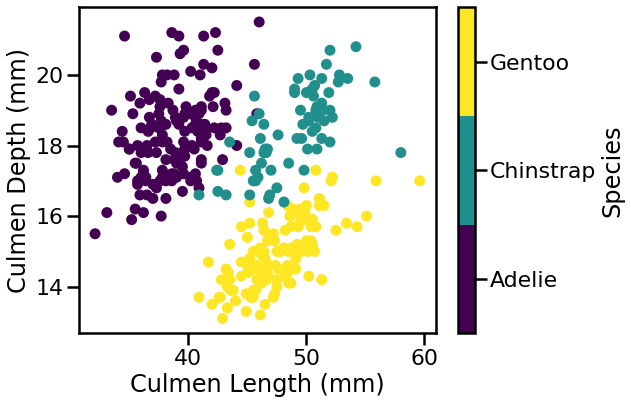

In [4]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(8, 6))

_ = data.plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="Species",
    s=80,
    cmap=plt.cm.viridis,
    ax=ax,
)

In this dataset, we have three species of penguin and we want to distinguish them based on the culmen depth and length.
Let's start to train a shallow decision tree classifier.

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

We will check qualitatively the statistical performance of our model by looking at the decision boundary and point-out the misclassified samples.

In [6]:
import numpy as np

target_predicted = tree.predict(X)
mask_misclassified = y != target_predicted

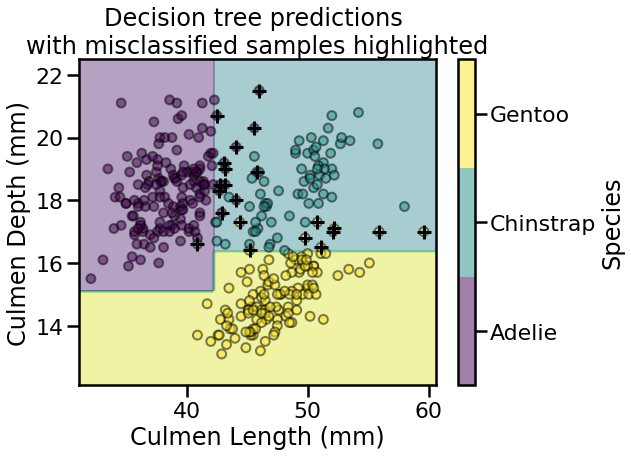

In [7]:
from helper.plotting import DecisionBoundaryDisplay

_, ax = plt.subplots(figsize=(8, 6))

# plot the decision boundaries
display = DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap=plt.cm.viridis,
    alpha=0.4, ax=ax,
)

# plot the original dataset
data.plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="Species",
    s=80,
    cmap=plt.cm.viridis,
    alpha=0.5,
    edgecolor="black",
    ax=ax,
)
# plot the misclassified samples
data[mask_misclassified].plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="black",
    s=200,
    marker="+",
    ax=ax,
)

_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

We observe that our decision tree is making a couple of error for some Gentoo and Adelie samples. What we would be interested in now is to train a new decision tree but that should only focus on the misclassified samples this time. Scikit-learn exposes a `sample_weight` parameter in the `fit` method that allows to give more weight to some specific sample. We will use this parameter to only focus our new decision tree on the misclassified samples.

In [8]:
sample_weight = mask_misclassified.astype(np.float64)

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

Let's check the decision boundary of this newly trained decision tree classifier.

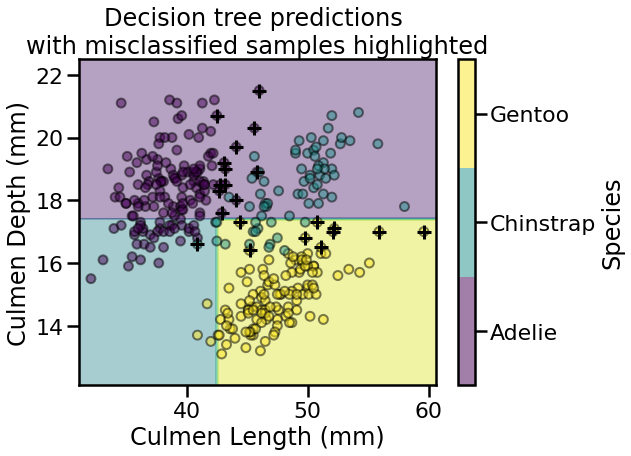

In [9]:
_, ax = plt.subplots(figsize=(8, 6))

# plot the decision boundaries
display = DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap=plt.cm.viridis,
    alpha=0.4,
    ax=ax,
)

# plot the original dataset
data.plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="Species",
    s=80,
    cmap=plt.cm.viridis,
    alpha=0.5,
    edgecolor="black",
    ax=ax,
)
# plot the misclassified samples
data[mask_misclassified].plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="black",
    s=200,
    marker="+",
    ax=ax,
)

_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

In [10]:
target_predicted = tree.predict(X)
mask_new_misclassifier = y != target_predicted
remaining_misclassified_samples_idx = (
    mask_misclassified & mask_new_misclassifier
)

print(f"Number of samples previously misclassified and "
      f"still misclassified: {remaining_misclassified_samples_idx.sum()}")

Number of samples previously misclassified and still misclassified: 0


We can observe that the previously misclassified samples are well classified now. However, it comes at the cost of misclassifying some other samples. We could continue by training a serie of decision tree classifiers. However, at some point, we need to find a way to combine them. One way could be that we could trust more or less a classifier depending on the ratio of good classification on the full training set.

In [11]:
ensemble_weight = [
    (y.size - mask_misclassified.sum()) / y.size,
    (y.size - mask_new_misclassifier.sum()) / y.size,
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

In our example, the first classification has a good accuracy and we will trust it more than the second classifier. Thus, we could make a linear combination of the different decision tree classifiers.

The algorithm that we just did is a simplification of an algorithm known as `AdaBoostClassifier`.

<div class="alert alert-success">
    <b>EXERCISE:</b>:
    <br>
    <ul>
        <li>Train a <tt>sklearn.ensemble.AdaBoostClassifier</tt> with 3 estimators and where the base estimator is a <tt>DecisionTreeClassifier</tt> with a <tt>max_depth=3</tt>.</li>
        <li>Once this classifier trained, access the fitted attribute <tt>estimators_</tt> that contains the different decision tree classifiers and plot their decision boundary.</li>
        <li>What are the weights associated with each decision tree classifiers.</li>
    </ul>
</div>

In [16]:
# %load solutions/solution_20.py
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(
    base_estimator=base_estimator,
    n_estimators=3, algorithm="SAMME",
    random_state=0
)
adaboost.fit(X, y)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

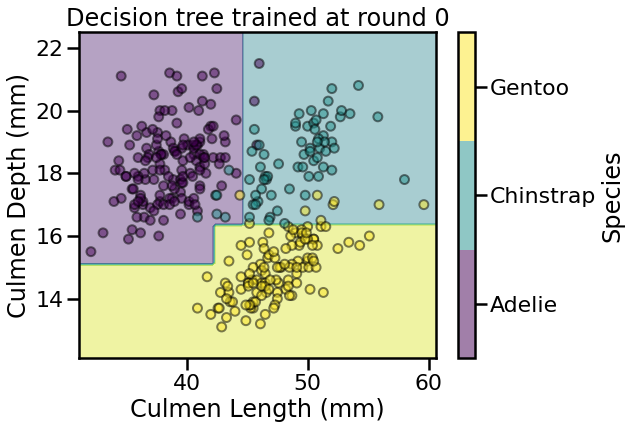

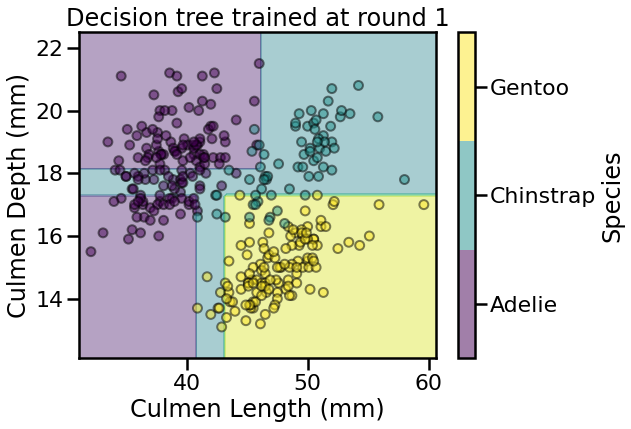

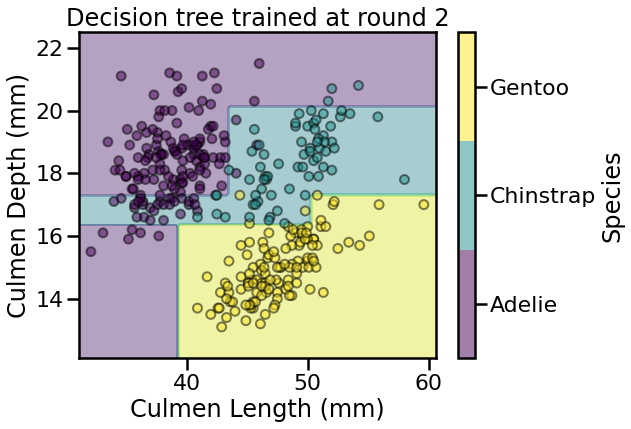

In [17]:
# %load solutions/solution_21.py
for boosting_round, tree in enumerate(adaboost.estimators_):
    _, ax = plt.subplots(figsize=(8, 6))
    display = DecisionBoundaryDisplay.from_estimator(
        tree, X, response_method="predict", cmap=plt.cm.viridis,
        alpha=0.4,
        ax=ax,
    )
    data.plot.scatter(
        x="Culmen Length (mm)",
        y="Culmen Depth (mm)",
        c="Species",
        s=80,
        cmap=plt.cm.viridis,
        alpha=0.5,
        edgecolor="black",
        ax=ax,
    )
    _ = ax.set_title(f"Decision tree trained at round {boosting_round}")


In [18]:
# %load solutions/solution_22.py
print(f"Weight of each classifier: {adaboost.estimator_weights_}")


Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [19]:
# %load solutions/solution_23.py
print(f"Error of each classifier: {adaboost.estimator_errors_}")


Error of each classifier: [0.05263158 0.05864198 0.08787269]


## Gradient Boosting Decision Trees

AdaBoost predictors are less use nowadays in practice. Instead, gradient boosting decision trees are used and have been demonstrated to be better models.

In gradient boosting, each estimator will be a decision tree regressor even in classification. Using a regression tree allows to get a continuous residuals. Each estimator to be added in the sequence of estimator will be trained on the residuals of the previous estimators. In addition, there are a couple of parameters allowing to correct more or less fast the residuals from previous estimators.

Let's illustrate such model on a classification task.

In [20]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("../datasets/adult-census-numeric-all.csv")
X, y = data.drop(columns="class"), data["class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(n_estimators=5)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=5)

In [22]:
classifier.score(X_test, y_test)

0.8056670215379576

We can inspect the different underlying estimators to show that we used indeed decisiont tree regressor even in a classification setting.

In [23]:
classifier.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x20BDF95EBF8)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x20BDF95EBF8)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x20BDF95EBF8)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x20BDF95EBF8)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x20BDF95EBF8)]],
      dtype=object)

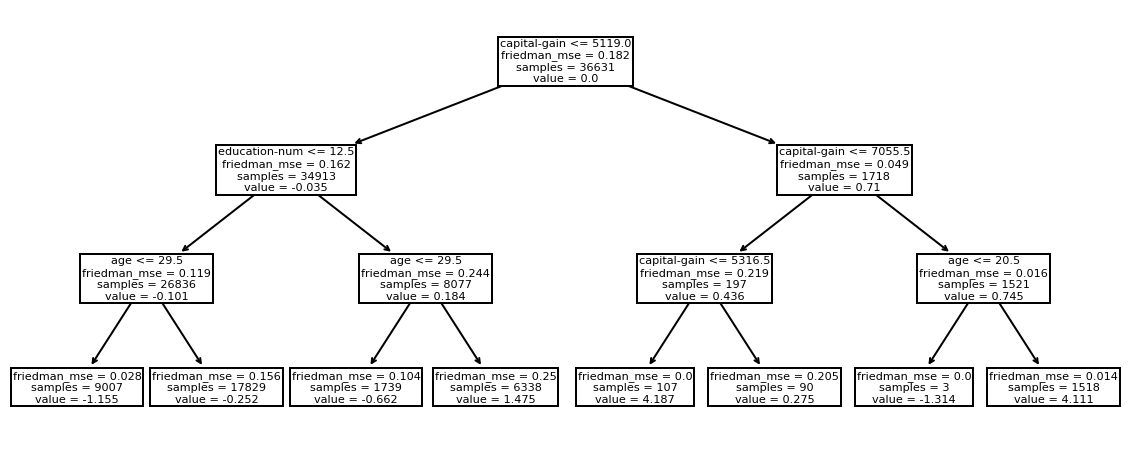

In [24]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(20, 8))

_ = plot_tree(
    classifier.estimators_[0][0],
    feature_names=X_train.columns,
    ax=ax,
)

### Histogram gradient boosting decision trees

<div class="alert alert-success">
    <b>ACCELERATE GRADIENT BOOSTING</b>:
    <ul>
        <li>Which solution would you use to accelerate the training speed of gradient boosting algorithm.</li>
    </ul>
</div>

## Short introduction of `KBinsDiscretizer`

We will show a trick to accelerate gradient boosting and more generally decision tree. When presenting decision trees, we mentioned that a split is chosen among all possible available splits that are defined by the unique values available in a given feature. One can reduce the amount of splits by binning the values of a feature beforehand and only consider the bin edges as potential edge. Since gradient boosting is ensembling several model, the lack of available splits will be attenuated by the size of the ensemble.

Here, we show that you can bin a dataset in scikit-learn using the `KBinsDiscritizer`.

In [25]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(
    n_bins=10, encode="ordinal", strategy="uniform"
)
X_trans = discretizer.fit_transform(X)
X_trans

array([[1., 4., 0., 0., 3.],
       [2., 5., 0., 0., 5.],
       [1., 7., 0., 0., 3.],
       ...,
       [5., 5., 0., 0., 3.],
       [0., 5., 0., 0., 1.],
       [4., 5., 1., 0., 3.]])

In [26]:
[len(np.unique(col)) for col in X_trans.T]

[10, 10, 6, 10, 10]

Here, we decided to use 10 bins for each features.

<div class="alert alert-success">
    <b>EXERCISE</b>:
    <ul>
        <li>Create a pipeline composed of a <tt>KBinsDiscretizer</tt> followed by a <tt>GradientBoostingClassfier</tt>.</li>
        <li>Compare the training time with the vanilla <tt>GradientBoostingClassifier</tt>.</li>
    </ul>
</div>

In [61]:
from sklearn.pipeline import make_pipeline

n_estimators = 100

In [62]:
%%time

make_pipeline(discretizer, GradientBoostingClassifier(n_estimators=n_estimators)).fit(X, y)

Wall time: 4.66 s


Pipeline(steps=[('kbinsdiscretizer',
                 KBinsDiscretizer(encode='ordinal', n_bins=10,
                                  strategy='uniform')),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [64]:
%%time

GradientBoostingClassifier(n_estimators=n_estimators).fit(X, y)

Wall time: 6.55 s


GradientBoostingClassifier()

In [65]:
# %load solutions/solution_24.py

In [66]:
# %load solutions/solution_25.py

In [67]:
# %load solutions/solution_26.py

In [68]:
# %load solutions/solution_27.py

Scikit-learn provides `HistGradientBoostingClassifier` which is an approximate gradient boosting algorithm similar to `lightgbm` and `xgboost`.

In [69]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=200, max_bins=10)
clf.fit(X_train, y_train)

Wall time: 1.97 s


HistGradientBoostingClassifier(max_bins=10, max_iter=200)

In [70]:
clf.score(X_test, y_test)

0.8099254770289084

### Hyperparameters

For gradient-boosting, parameters are coupled, so we cannot set the parameters one after the other anymore. The important parameters are `n_estimators`, `max_depth`, and `learning_rate`.

Let’s first discuss the `max_depth` parameter. We saw in the section on gradient-boosting that the algorithm fits the error of the previous tree in the ensemble. Thus, fitting fully grown trees will be detrimental. Indeed, the first tree of the ensemble would perfectly fit (overfit) the data and thus no subsequent tree would be required, since there would be no residuals. Therefore, the tree used in gradient-boosting should have a low depth, typically between 3 to 8 levels. Having very weak learners at each step will help reducing overfitting.

With this consideration in mind, the deeper the trees, the faster the residuals will be corrected and less learners are required. Therefore, `n_estimators` should be increased if `max_depth` is lower.

Finally, we have overlooked the impact of the `learning_rate` parameter until now. When fitting the residuals, we would like the tree to try to correct all possible errors or only a fraction of them. The learning-rate allows you to control this behaviour. A small learning-rate value would only correct the residuals of very few samples. If a large learning-rate is set (e.g., 1), we would fit the residuals of all samples. So, with a very low learning-rate, we will need more estimators to correct the overall error. However, a too large learning-rate tends to obtain an overfitted ensemble, similar to having a too large tree depth.

We will come back in the next chapter how to find the best set of hyperparameters in practice.

An option that is useful in histogram gradient boosting is the `early_stopping` parameter. This will split the data internally during `fit` and use a validation set to assess the improvement of adding a new decision tree regressor. If the model detect that adding new estimators will not improve the statistical performance of the model, it will stop the `fit` process. Let's check in practice how it works:

In [75]:
model = HistGradientBoostingClassifier(early_stopping=True, max_iter=1_000)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(early_stopping=True, max_iter=1000)

We requested 1,000 decision trees that is more than we actually need to fit the data at hand. We can now check the number of trees that has been added in the model:

In [76]:
model.n_iter_

115

We see that the gradient boosting stopped the learning process after 127 decision trees.